In [1]:
import dv_processing as dv
import torch
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader_refac import ModelLoader
from snn_delays.utils.train_utils_refact_minimal import get_device
from snn_delays.utils.hw_aware_utils import quantize_weights
from snn_delays.utils.hw_aware_utils import save_weights_delays, save_state
import numpy as np
import os
device = get_device() 

# For reproducibility
torch.manual_seed(10)

Running on: cuda:0


In [2]:
add_name = '_q8'

# ckpt_dir = 'abcxo' # 250, 1e6
# model = 'abcxo_f_9233333333333333' #45x45

# ckpt_dir = 'abcxo_32' # 250, 1e6
# model = 'abcxo_f_9916666666666667' #32x32

ckpt_dir = 'abcxo_32_24' # 250, 1e6
model = 'abcxo_f_9783333333333333'

In [3]:
dataset = 'davis'
total_time = 50
batch_size = 64
folder_name = 'ABCXO'
size = 32 # or 45

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = size,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

snn = ModelLoader(model, ckpt_dir, batch_size, device) 

[CenterCrop(sensor_size=(240, 180, 2), size=(180, 180)), Downsample(time_factor=1, spatial_factor=0.17777777777777778, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]
Delta t: 5.0 ms
Delta t: 5.0 ms
Delta t: 5.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [4]:
snn.input2spike_th = 0.5
_, __ = snn.test(test_loader)

600
Test Loss: 0.020447793509811164
Avg spk_count per neuron for all 50 time-steps 306.3041666666667
Test Accuracy of the model on the test samples: 97.833



In [5]:
weight_params_names = [name for name, param in snn.named_parameters() if 'linear' in name]

In [6]:
weight_params_names

['layers.0.linear.weight', 'layers.1.linear.weight', 'layers.2.linear.weight']

In [7]:
def getattr_dotted(obj, attr_str):
    for attr in attr_str.split('.'):
        obj = getattr(obj, attr)
    return obj
getattr_dotted(snn, weight_params_names[0])

Parameter containing:
tensor([[-1.2082e-02, -1.1724e-02, -1.6690e-02,  ..., -1.3196e-03,
         -4.2319e-03,  1.1606e-02],
        [-6.0880e-03, -9.7693e-03,  1.3288e-02,  ...,  1.4772e-02,
          5.2610e-03,  1.3207e-02],
        [ 6.2053e-03,  2.1441e-02,  1.4955e-02,  ...,  3.7887e-04,
          9.3093e-03,  1.4188e-03],
        ...,
        [ 3.0153e-03,  1.3389e-02, -1.0711e-02,  ...,  2.5626e-03,
          3.2692e-02,  5.0650e-03],
        [-1.7103e-05, -2.9227e-02, -1.4592e-02,  ...,  8.3793e-03,
         -6.3815e-03,  1.7210e-02],
        [-8.2405e-02,  1.9989e-02, -5.0347e-03,  ..., -3.1631e-02,
         -3.7999e-02, -4.0604e-02]], device='cuda:0', requires_grad=True)

### Weight quantization

In [8]:
quantize_weights(snn, 8, last_layer=True, symmetry=True, print_info=True)
_, __ = snn.test(test_loader)

----layers.0.linear.weight----
n_unique before quantization: 49135, 24236 pos 24899 neg
max_value before quantization: 0.1242036372423172
n_unique after quantization: 216, 109 pos 106 neg
max_value after quantization: 0.12323329597711563, delta_w: 0.0009703409159556031
----layers.1.linear.weight----
n_unique before quantization: 576, 277 pos 299 neg
max_value before quantization: 0.4930714964866638
n_unique after quantization: 153, 74 pos 78 neg
max_value after quantization: 0.4892193675041199, delta_w: 0.003852121066302061
----layers.2.linear.weight----
n_unique before quantization: 120, 50 pos 70 neg
max_value before quantization: 0.5507662296295166
n_unique after quantization: 93, 42 pos 51 neg
max_value after quantization: 0.5464633703231812, delta_w: 0.008605722337961197
600
Test Loss: 0.019840709771960972
Avg spk_count per neuron for all 50 time-steps 306.3041666666667
Test Accuracy of the model on the test samples: 97.833



<AxesSubplot:>

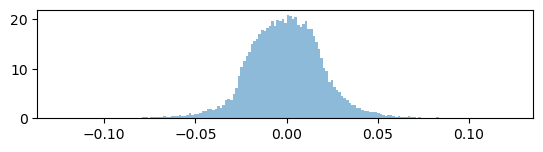

In [9]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
plt.subplot(311)
plot_param(snn.layers[0].linear, 'histogram_nonzero')
# plt.subplot(312)
# plot_param(snn.f1_o, 'histogram_nonzero')
# plt.subplot(313)
# plot_param(snn.f2_o, 'histogram_nonzero')

### Save weights, delays, spikes and mems

In [10]:
ckpt_dir_2 = 'weights_' + model + add_name
save_path = os.path.join(
    os.environ.get('SNN_CHECKPOINTS_PATH'), ckpt_dir, ckpt_dir_2)

save_weights_delays(snn, path=save_path)

no delays in this network. setting all delays to zero.
no delays in this network. setting all delays to zero.
no delays in this network. setting all delays to zero.
Weights and delays saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_32_24\weights_abcxo_f_9783333333333333_q8
